# Vertical wind shear

## Import montly wind Data at different pressure and surface pressure data - ERA5

In [114]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

In [115]:
sp = xr.open_dataset("data/adaptor.mars.internal-1620347471.6475074-21232-27-e1c9f315-4809-4a75-9b4b-35ca2acae1f1.nc")
wind = xr.open_dataset("data/adaptor.mars.internal-1620349801.4036198-26247-18-78581c13-c929-45d4-86ba-1a529f155a05.nc")

In [116]:
# select time period
wind_9020 = wind.sel(time=slice("1990-01-01", "2019-12-31"))
wind_9020

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 121, level: 6, longitude: 161, time: 360)
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 10.0 9.75 9.5 9.25 ... -19.5 -19.75 -20.0
  * level      (level) int32 300 350 400 450 500 550
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2019-12-01
Data variables:
    u          (time, expver, level, latitude, longitude) float32 ...
    v          (time, expver, level, latitude, longitude) float32 ...
    w          (time, expver, level, latitude, longitude) float32 ...
    vo         (time, expver, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-05-07 01:25:06 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [117]:
#Combine ERA5 and ERA5_T
wind_9020 =wind_9020.sel(expver=1).combine_first(wind_9020.sel(expver=5))
sp =sp.sel(expver=1).combine_first(sp.sel(expver=5))
wind_9020.load()
# sp.load()

<xarray.Dataset>
Dimensions:    (latitude: 121, level: 6, longitude: 161, time: 360)
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 10.0 9.75 9.5 9.25 ... -19.5 -19.75 -20.0
  * level      (level) int32 300 350 400 450 500 550
  * time       (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2019-12-01
Data variables:
    u          (time, level, latitude, longitude) float32 10.03 10.12 ... 2.296
    v          (time, level, latitude, longitude) float32 1.142 1.118 ... -2.799
    w          (time, level, latitude, longitude) float32 0.03378 ... -0.01443
    vo         (time, level, latitude, longitude) float32 1.573e-07 ... 3.181...
Attributes:
    Conventions:  CF-1.6
    history:      2021-05-07 01:25:06 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [151]:
sp

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 161, time: 508)
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 10.0 9.75 9.5 9.25 ... -19.5 -19.75 -20.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-04-01
Data variables:
    sp         (time, latitude, longitude) float32 1.011e+05 ... 1.014e+05
Attributes:
    Conventions:  CF-1.6
    history:      2021-05-07 00:34:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

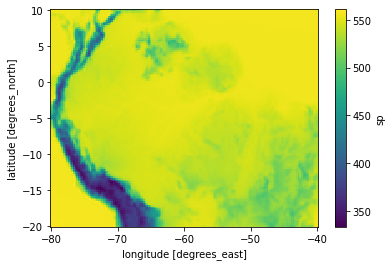

In [118]:
# calculate mean surface pressure
sp_xarray = sp.mean(dim = "time",keep_attrs=True)
sp_xarray['sp'] = sp_xarray.sp*0.01 #convert Pa to hPa

# Calculate pressure at 6km
# "take the upper-level winds from the pressure level equal to the
# mean of the surface pressure and 100 mbar" -- Seeley, J.T. and Romps, D.M., 2015. 
# The effect of global warming on severe thunderstorms in the United States. 
# Journal of Climate, 28(6), pp.2443-2458.
mean_hPa_6km = (sp_xarray.sp+100)/2
mean_hPa_6km.plot()

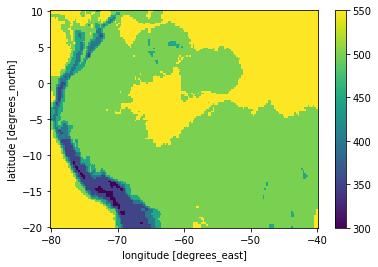

In [120]:
# convert pressure at 6km to 350,400,450,500,550
p_6km = np.zeros(mean_hPa_6km.shape)
col = len(mean_hPa_6km[0])
row = len(mean_hPa_6km)

for i in range(row):
    for j in range(col):
        if mean_hPa_6km[i][j] >= 500 and mean_hPa_6km[i][j] < 550:
            p_6km[i][j] = 500
        elif mean_hPa_6km[i][j] >= 550 and mean_hPa_6km[i][j] < 600:
            p_6km[i][j] = 550
        elif mean_hPa_6km[i][j] >= 450 and mean_hPa_6km[i][j] < 500:
            p_6km[i][j] = 450
        elif mean_hPa_6km[i][j] >= 400 and mean_hPa_6km[i][j] < 450:
            p_6km[i][j] = 400
        elif mean_hPa_6km[i][j] >= 350 and mean_hPa_6km[i][j] < 400:
            p_6km[i][j] = 350
        elif mean_hPa_6km[i][j] >= 300 and mean_hPa_6km[i][j] < 350:
            p_6km[i][j] = 300
          
p_coords = sp_xarray.coords            
p = xr.DataArray(p_6km, coords = p_coords)

p.plot()

# wind shear 1990-2019

In [135]:
# average over time
wind_xarray = wind_9020.mean(dim = "time",keep_attrs=True)
wind_xarray

<xarray.Dataset>
Dimensions:    (latitude: 121, level: 6, longitude: 161)
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 10.0 9.75 9.5 9.25 ... -19.5 -19.75 -20.0
  * level      (level) int32 300 350 400 450 500 550
Data variables:
    u          (level, latitude, longitude) float32 0.3077 0.3447 ... 3.014
    v          (level, latitude, longitude) float32 1.343 1.333 ... -0.4405
    w          (level, latitude, longitude) float32 -0.05075 ... 0.01672
    vo         (level, latitude, longitude) float32 -6.954e-06 ... 7.36e-06
Attributes:
    Conventions:  CF-1.6
    history:      2021-05-07 01:25:06 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [125]:
# select the wind data at specific pressure (represent 6km)
wind_6km = wind_xarray.sel(level = p)
wind_6km

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 161)
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 10.0 9.75 9.5 9.25 ... -19.5 -19.75 -20.0
    level      (latitude, longitude) int64 550 550 550 550 ... 500 500 550 550
Data variables:
    u          (latitude, longitude) float32 -4.378 -4.395 ... 2.983 3.014
    v          (latitude, longitude) float32 0.6023 0.6027 ... -0.4393 -0.4405
    w          (latitude, longitude) float32 -0.02653 -0.02747 ... 0.01672
    vo         (latitude, longitude) float32 2.016e-06 7.348e-07 ... 7.36e-06
Attributes:
    Conventions:  CF-1.6
    history:      2021-05-07 01:25:06 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [126]:
# calculate wind speed
wind_u = wind_6km.u
wind_v = wind_6km.v
wind = np.sqrt(wind_u**2+wind_v**2)
wind_ds = wind.to_dataset(name = 'wind')
wind_ds

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 161)
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 10.0 9.75 9.5 9.25 ... -19.5 -19.75 -20.0
    level      (latitude, longitude) int64 550 550 550 550 ... 500 500 550 550
Data variables:
    wind       (latitude, longitude) float32 4.419 4.436 4.436 ... 3.015 3.046

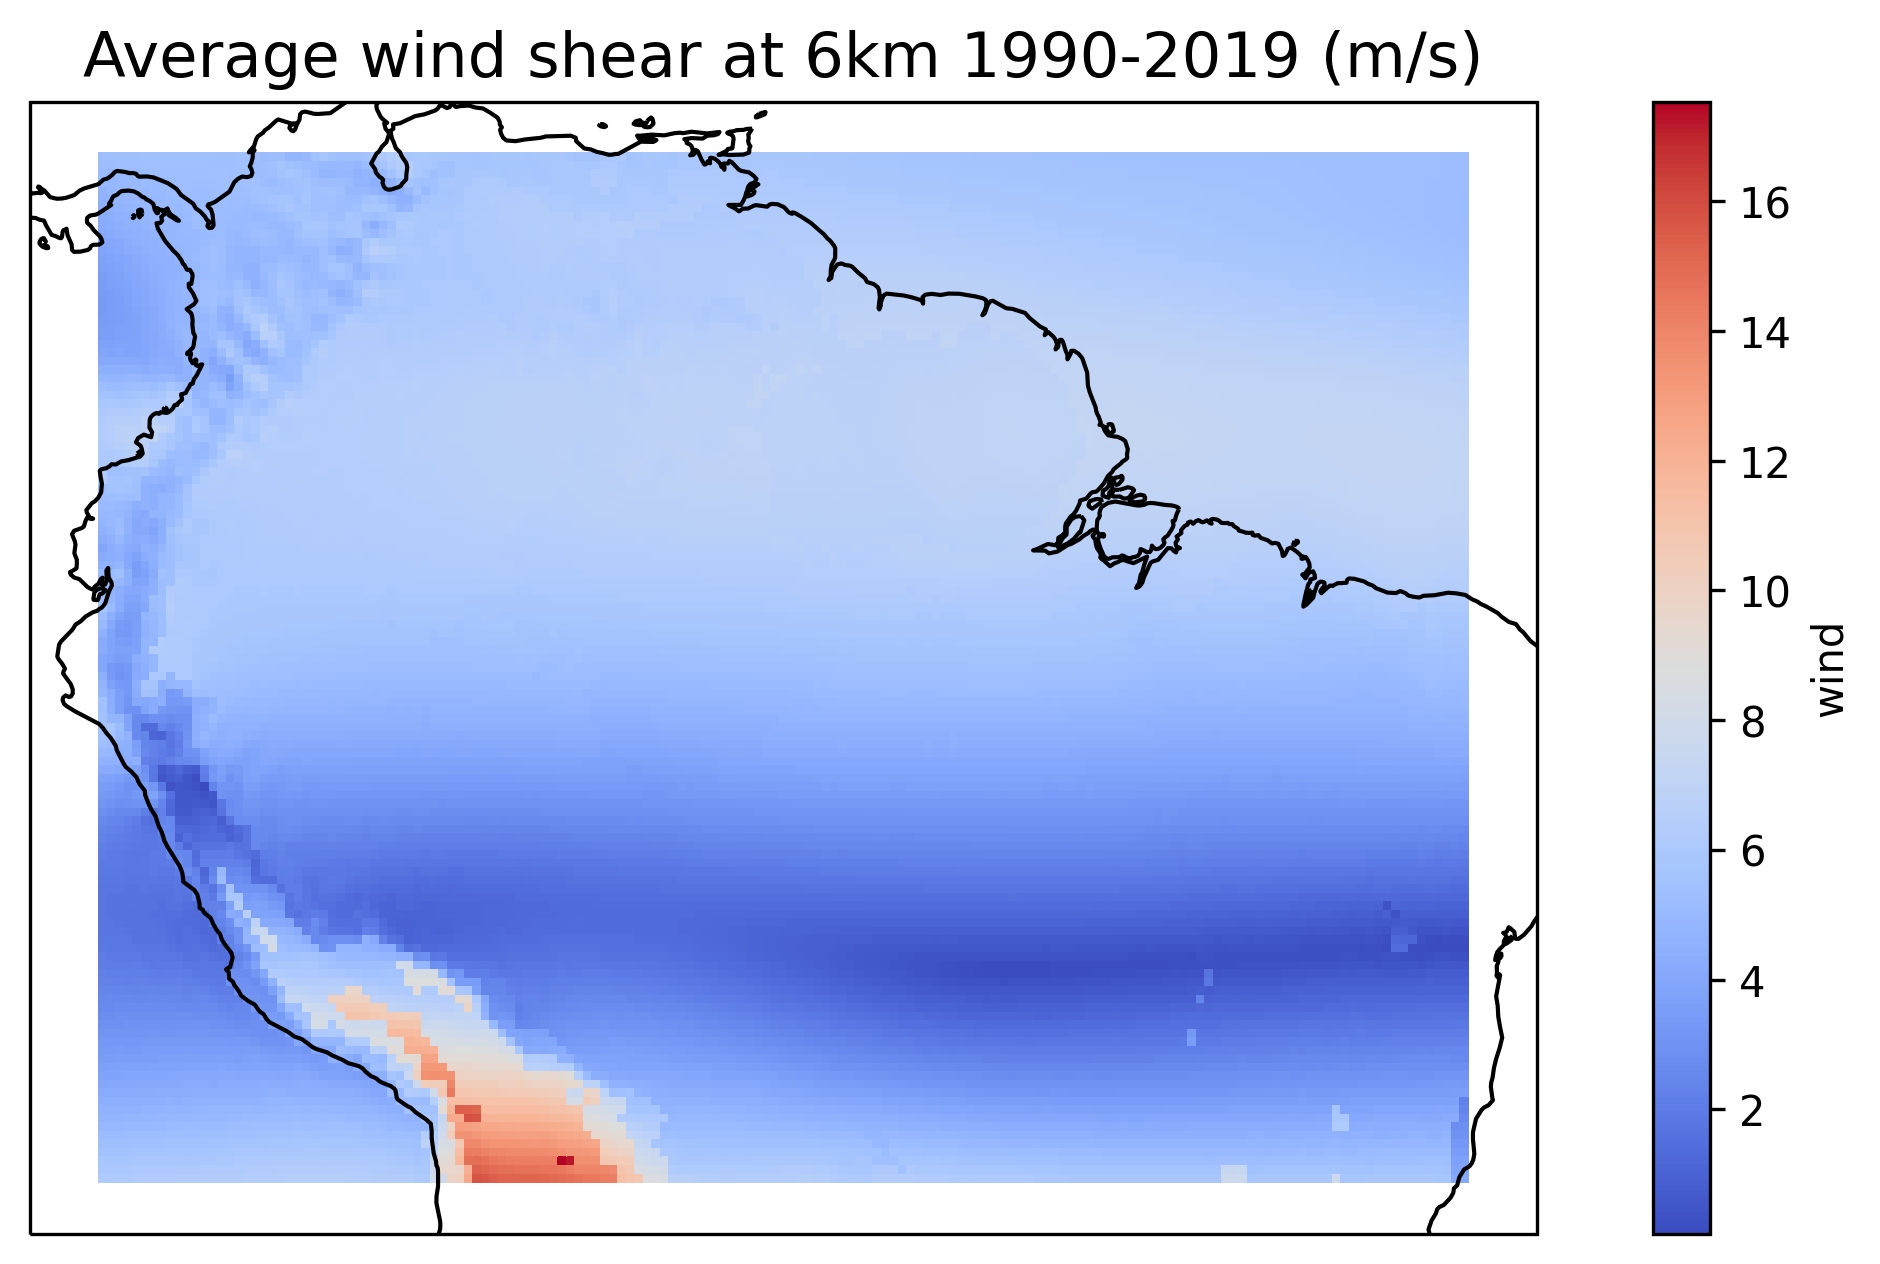

In [153]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
fig, ax1 = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 5), dpi=300, squeeze=True)
wind_ds.wind.plot(cmap = 'coolwarm', ax = ax1)

plt.title('Average wind shear at 6km 1990-2019 (m/s)',fontsize=15)
ax1.coastlines()




In [132]:
import rioxarray
xds = wind_ds
xds.rio.write_crs("epsg:4326", inplace=True)
# Then, you should be able to create a geotiff from the Evapotranspiration like so:

xds.rio.to_raster('ERA5-vertical-wind-shear.tif')


# wind 1990-2020 only summer and fall season

In [142]:
wind_xarray = wind_9020.groupby("time.season").mean(dim = "time",keep_attrs=True)
wind_SONJJA= wind_xarray.sel(season = ["SON","JJA"]).mean(dim = "season")
wind_6km = wind_SONJJA.sel(level = p)
wind_6km

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 161)
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 10.0 9.75 9.5 9.25 ... -19.5 -19.75 -20.0
    level      (latitude, longitude) int64 550 550 550 550 ... 500 500 550 550
Data variables:
    u          (latitude, longitude) float32 -5.186 -5.224 -5.24 ... 4.097 4.149
    v          (latitude, longitude) float32 1.143 1.146 1.161 ... 0.359 0.3625
    w          (latitude, longitude) float32 -0.06385 -0.06409 ... 0.03198
    vo         (latitude, longitude) float32 3.567e-06 2.698e-06 ... 8.349e-06

In [143]:
wind_u = wind_6km.u
wind_v = wind_6km.v
wind = np.sqrt(wind_u**2+wind_v**2)
wind_ds = wind.to_dataset(name = 'wind')
wind_ds

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 161)
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 10.0 9.75 9.5 9.25 ... -19.5 -19.75 -20.0
    level      (latitude, longitude) int64 550 550 550 550 ... 500 500 550 550
Data variables:
    wind       (latitude, longitude) float32 5.31 5.348 5.367 ... 4.113 4.165

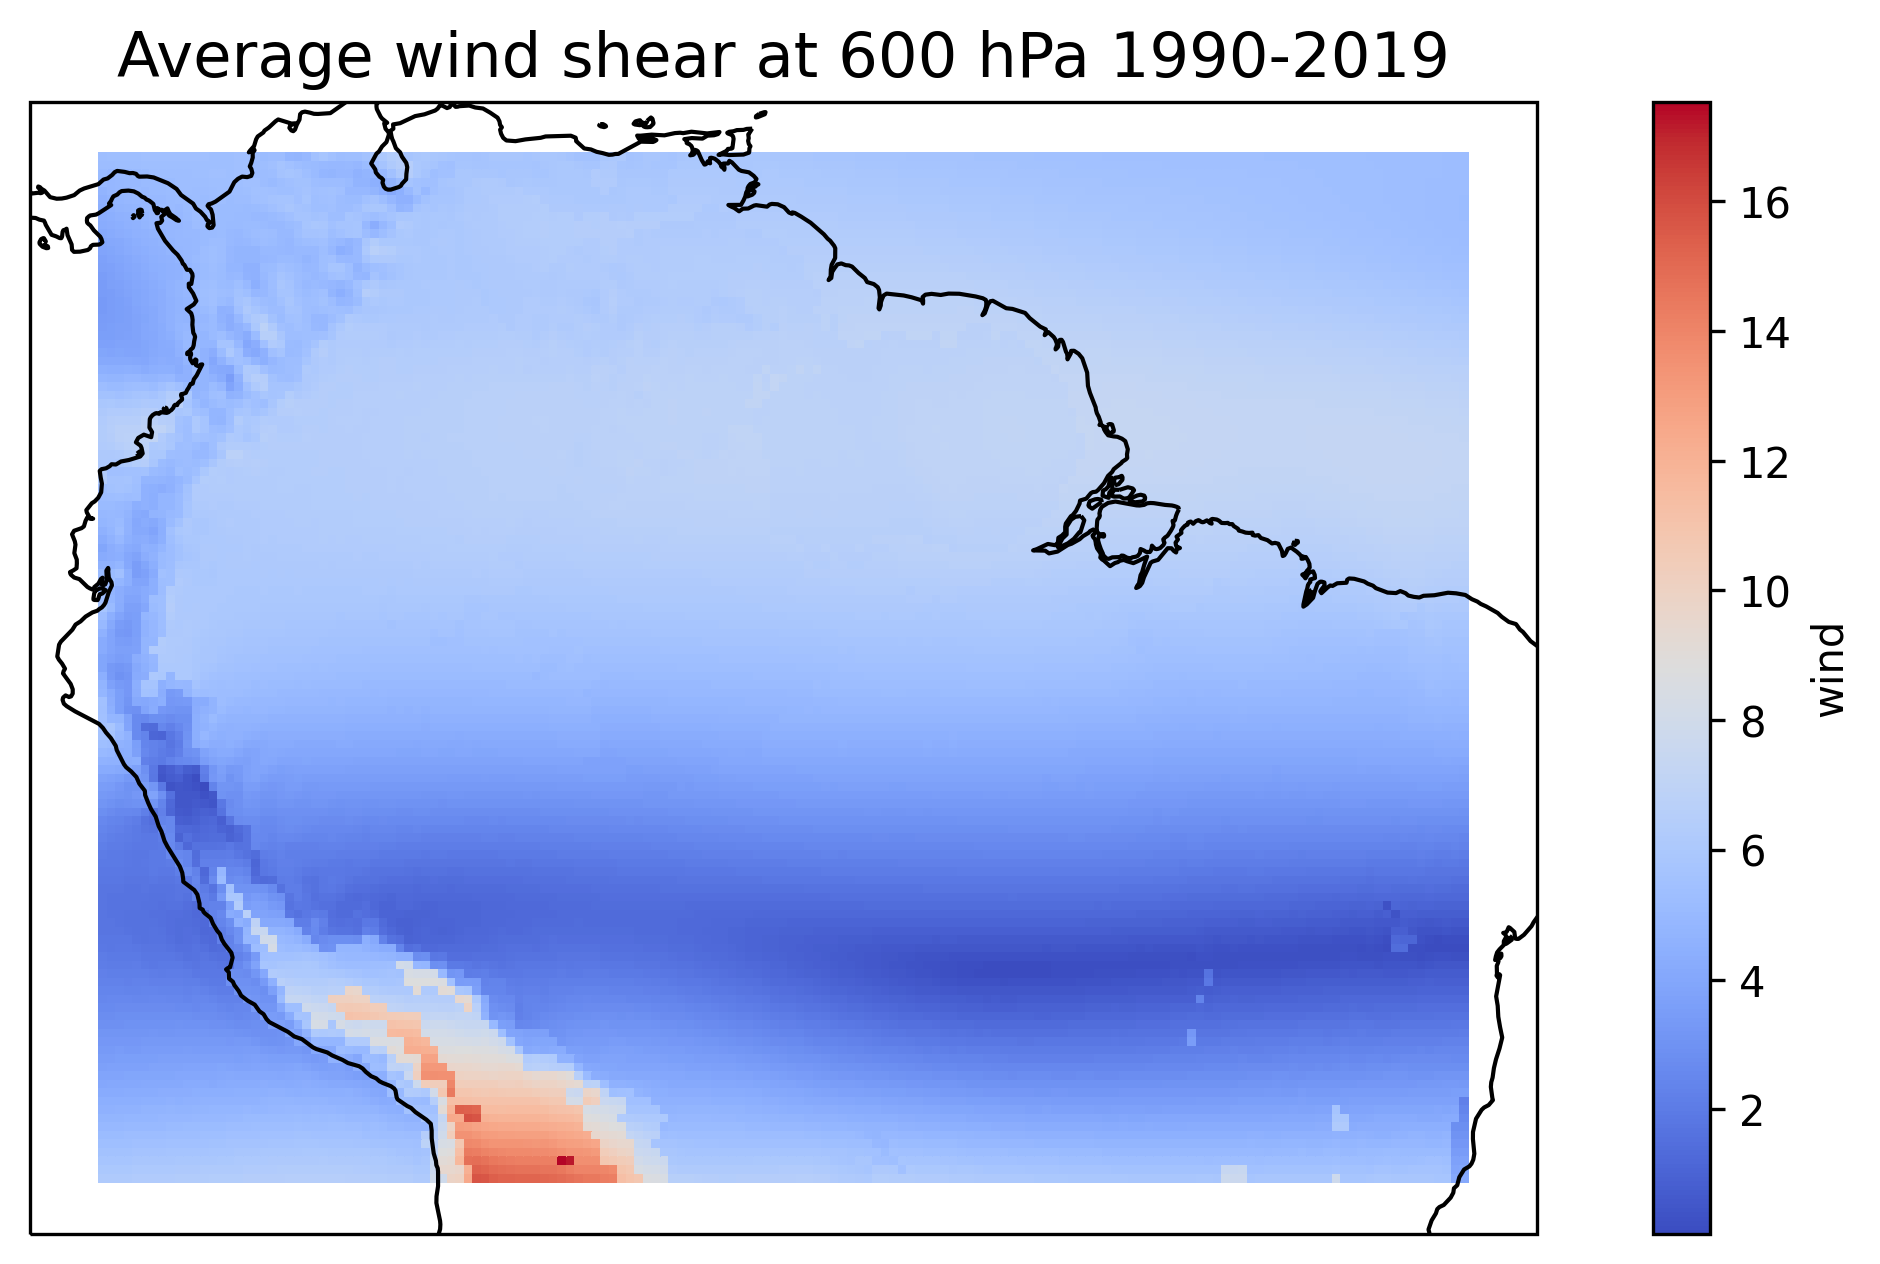

In [144]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
fig, ax1 = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 5), dpi=300, squeeze=True)
wind_ds.wind.plot(cmap = 'coolwarm', ax = ax1)

plt.title('Average wind shear at 600 hPa 1990-2019',fontsize=15)
ax1.coastlines()



In [145]:
import rioxarray
xds = wind_ds
xds.rio.write_crs("epsg:4326", inplace=True)
# Then, you should be able to create a geotiff from the Evapotranspiration like so:

xds.rio.to_raster('ERA5-vertical-wind-shear-SONJJA.tif')

# time series

In [150]:
# wind_ts = wind_9020.mean(dim=['latitude','longitude']).groupby('time.dayofyear').mean('time')
# wind_ts